In [22]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
torch.manual_seed(30)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = 'data/plantvillage'
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

In [24]:
train, val, test = torch.utils.data.random_split(image_datasets, [0.9, 0.05, 0.05])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

No of train: 48875 | No of val: 2715 | No of test: 2715 | 


In [25]:
# data transforms

mean =  np.array([0.4664, 0.4891, 0.4104])
std =  np.array([0.1761, 0.1500, 0.1925])

# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
data_transformer = {
	'train':
		transforms.Compose([
		transforms.RandomResizedCrop(244),
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
	'val':
		transforms.Compose([
		transforms.CenterCrop(244),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
	'deploy':
		transforms.Compose([
		transforms.CenterCrop(244),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
}

In [26]:
transform = transforms.ToTensor()
class PlantVillageDataset(Dataset):
	def __init__(self, datasets, transform=None):
		self.dataset = datasets
		self.transform = transform
		
	def __getitem__(self, index):
		if self.transform:
			x = self.transform(self.dataset[index][0])
		else:
			x = self.dataset[index][0]
		y = self.dataset[index][1]
		return x, y

	def __len__(self):
		return len(self.dataset)

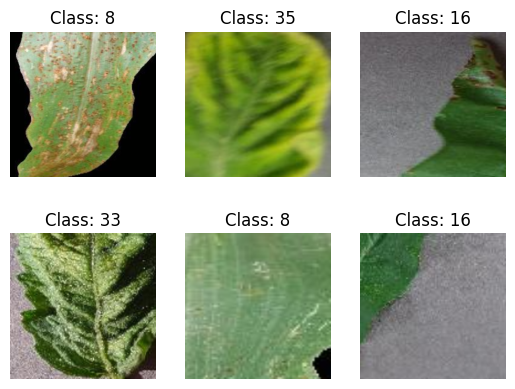

In [27]:
train_data = PlantVillageDataset(train, data_transformer['train'])
val_data = PlantVillageDataset(val, data_transformer['val'])
test_data = PlantVillageDataset(test, transform)

# Reverse normalization function
def reverse_normalize(image, mean, std):
	"""
	Reverse normalization of an image.
	Args:
		image (Tensor): Normalized image tensor (C, H, W).
		mean (tuple): Mean values for each channel.
		std (tuple): Standard deviations for each channel.
	Returns:
		image (ndarray): Denormalized image.
	"""
	mean = np.array(mean)
	std = np.array(std)
	image = image.numpy().transpose((1, 2, 0))
	image = std * image + mean
	image = np.clip(image, 0, 1)
	return image

# Preview transformed images
for i in range(6):
	plt.subplot(2, 3, i+1)
	image, label = train_data[i]
	image = reverse_normalize(image, mean, std)
	plt.imshow(image)
	plt.title(f'Class: {label}')
	plt.axis('off')

plt.show()


In [29]:
#hyperparameters
n_features = 23328
n_classes = 38
n_epochs = 20
batch_size = 64
learning_rate = 0.001


In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class ConvNet(nn.Module):
	def __init__(self, fc_dim):
		super(ConvNet, self).__init__()
		self.fc_dim = fc_dim
		self.sequential1 = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential2 = nn.Sequential(
			nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential3 = nn.Sequential(
			nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential4 = nn.Sequential(
			nn.Linear(self.fc_dim, 128),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(64, 38),
			# (n + 2p -f)/s + 1
		)
			
	def forward(self, x):
		out = self.sequential1(x)
		out = self.sequential2(out)
		out = self.sequential3(out)
		out = out.view(out.size(0), -1)
		out = self.sequential4(out)
		return out
	
model = ConvNet(n_features).to(device)
print(summary(model))
# use two gpu
# model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       456
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,416
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       12,832
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
├─Sequential: 1-4                        --
│    └─Linear: 2-10                      2,986,112
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      8,256
│    └─ReLU: 2-14                        --
│    └─Dropout: 2-15                     --
│    └─Linear: 2-16                      2,470
Total 

In [9]:
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


| Epoch: 1/50	| Loss: 1.5906 |
| Epoch: 2/50	| Loss: 1.4889 |
| Epoch: 3/50	| Loss: 1.3611 |
| Epoch: 4/50	| Loss: 1.2727 |
| Epoch: 5/50	| Loss: 0.9327 |
| Epoch: 6/50	| Loss: 0.9077 |
| Epoch: 7/50	| Loss: 0.6334 |
| Epoch: 8/50	| Loss: 1.0489 |
| Epoch: 9/50	| Loss: 0.8739 |
| Epoch: 10/50	| Loss: 0.6913 |
| Epoch: 11/50	| Loss: 0.6131 |
| Epoch: 12/50	| Loss: 0.7371 |
| Epoch: 13/50	| Loss: 1.0342 |
| Epoch: 14/50	| Loss: 0.9243 |
| Epoch: 15/50	| Loss: 0.8874 |
| Epoch: 16/50	| Loss: 1.0294 |
| Epoch: 17/50	| Loss: 0.4498 |
| Epoch: 18/50	| Loss: 0.9012 |
| Epoch: 19/50	| Loss: 0.8158 |
| Epoch: 20/50	| Loss: 0.6469 |
| Epoch: 21/50	| Loss: 0.3870 |
| Epoch: 22/50	| Loss: 0.7058 |
| Epoch: 23/50	| Loss: 0.6189 |
| Epoch: 24/50	| Loss: 1.1648 |
| Epoch: 25/50	| Loss: 0.6899 |
| Epoch: 26/50	| Loss: 0.5221 |
| Epoch: 27/50	| Loss: 0.5298 |
| Epoch: 28/50	| Loss: 0.7341 |
| Epoch: 29/50	| Loss: 0.5535 |
| Epoch: 30/50	| Loss: 0.5718 |
| Epoch: 31/50	| Loss: 0.6462 |
| Epoch: 32/50	|

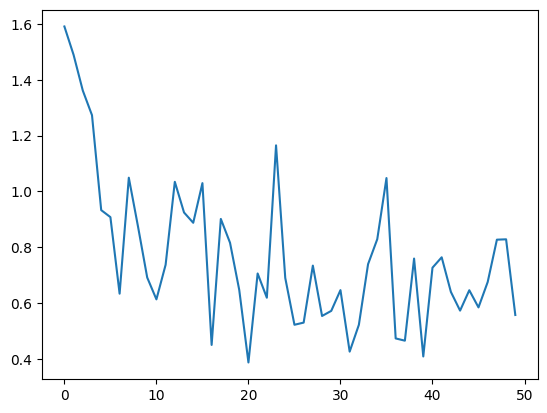

In [11]:
# Training loop
start_time = time.time()
n_total_steps = len(train_data_loader)
losses = []
print(f'\n {"="*30}')
for epoch in range(n_epochs):
	for i, (images, labels) in enumerate(train_data_loader):
		images = images.to(device)
		labels = labels.to(device)
		
		#forward
		outputs = model(images)
		loss = criterion(outputs, labels)
		#backward
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
	# if(epoch + 1) % 10 == 0:
	losses.append(loss.item())
	print(f'| Epoch: {epoch+1}/{n_epochs}\t| Loss: {loss.item():.4f} |')
print(f' {"="*30}\n')
end_time = time.time() - start_time
#Evaluation
with torch.no_grad():
	n_correct = 0
	n_samples = 0
	for images, labels in val_data_loader:
		images = images.to(device)
		labels = labels.to(device)
		outputs = model(images)
		
		_, predictions = torch.max(outputs, 1)
		n_samples += labels.shape[0]
		n_correct += (predictions == labels).sum().item()
	accuracy = n_correct * 100.0 / n_samples
	print(f'\tAccuracy: {accuracy:.2f}%')
print(f'\n {"="*30}\n')
print(f'  Training Time: {end_time/60:.2f} Minute(s)')
print(f'\n {"="*30}\n')
plt.plot(losses)
plt.show()

In [31]:
save_path = 'models/plantvillage-v2.pth'
torch.save(model.state_dict(), save_path)
# plantVillageModel = ConvNet(n_features).to(device)
plantVillageModel = torch.load(save_path)
plantVillageModel.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [ ]:
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=True)
test_sample_count = 10  # Changed to pick two images
n_samples = len(test_data_loader.dataset)  # Assuming test_data_loader is a DataLoader object with a dataset attribute

correct_count = 0
wrong_count = 0

for i in range(test_sample_count):
	random_index = random.randint(0, len(test_data_loader) - 1)
	for idx, (images, labels) in enumerate(test_data_loader):
		if idx == random_index:
			image = images
			label = labels
			break
	
	image = image.to(device)
	label = label.to(device)
	with torch.no_grad():
		output = plantVillageModel(image)
	_, prediction = torch.max(output, 1)
	
	# Check if prediction is correct
	is_correct = (prediction == label)
	correct_count += is_correct.item()
	wrong_count += int(not is_correct.item())

	# Convert tensors to numpy arrays and reverse normalization
	image = reverse_normalize(image.squeeze(), mean, std)
	label = label.item()
	prediction = prediction.item()
	
	# Plot the image along with its label
	plt.figure(figsize=(4, 4))
	plt.imshow(image)
	plt.title(f'Predicted: {prediction}, Actual: {label}')
	plt.axis('off')
	plt.show()

# Print the total counts
print(f'Total Correct Predictions: {correct_count}')
print(f'Total Wrong Predictions: {wrong_count}')

In [33]:
import torchvision.transforms as transforms
from PIL import Image

class ImageClassPredict():
	def __init__(self):
		
		self.image_transformer = transforms.Compose([
			transforms.CenterCrop(244),
			transforms.ToTensor(),
			transforms.Normalize(mean, std)
		])
		# self.image_path = image_path
		# self.model_path = model_path

	def load_image(self, image):
		image = Image.open(image).convert('RGB')  # Load the image using PIL and convert to RGB
		image = self.image_transformer(image)  # Apply data transformations
		return image

	def infer(self, model_pth):
		image = self.load_image(self.image_path)
		model = torch.load(model_pth)
		model.eval()
		with torch.no_grad():
				output = model(image)
		_, prediction = torch.max(output, 1)
		return prediction



# Function to preprocess the image
# def plant_infer(image_path):
# 	image = Image.open(image_path).convert('RGB')  # Load the image using PIL and convert to RGB
# 	image = data_transformer(image)  # Apply data transformations
# 	return image

# Image path
img_path = 'data/plantvillage/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'
model_path = 'models/plantvillage-v2.pth'
model = ImageClassPredict.load_image(img_path)
prediction = ImageClassPredict.infer(model_path)
# Preprocess the image
# im = plant_infer(img_path)

# Plot the image
plt.figure(figsize=(4, 4))
plt.imshow(im.permute(1, 2, 0))  # Permute dimensions to (H, W, C) for matplotlib
plt.title('Preprocessed Image')
plt.axis('off')
plt.show()


TypeError: ImageClassPredict.load_image() missing 1 required positional argument: 'image'